In [1]:
import pink_utils as pu
import pandas as pd
import numpy as np

In [2]:
hm = pu.heatmap('../Experiment/Experiment_F3W2_95_5/F3W2_95_5_Testing_Images_EDMatrix.bin')
images = pu.image_binary('../Experiment/Experiment_F3W2_95_5/F3W2_95_5_Testing_Images.bin')

In [3]:
df = pd.read_csv('../Experiment/Experiment_F3W2_95_5/Test_Images/RGZ_Test_Images_Dataframe.csv')

In [4]:
df.shape

(7464, 78)

In [5]:
images.file_head

(7464, 2, 167, 167)

In [6]:
hm.file_head

(7464, 15, 15, 1)

In [7]:
maps = [hm.ed(index=i, prob=True) for i in range(hm.file_head[0])]

In [8]:
first = [images.get_image(index=i, channel=0) for i in range(hm.file_head[0])]

In [9]:
wise = [images.get_image(index=i, channel=1) for i in range(hm.file_head[0])]

In [10]:
import matplotlib.pyplot as plt

/Users/gal16b/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


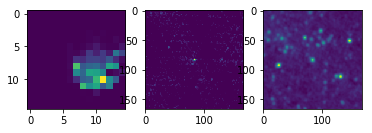

In [11]:
fig, ax = plt.subplots(1,3)
c = 103
ax[0].imshow(maps[c])
ax[1].imshow(first[c])
ax[2].imshow(wise[c])

fig.show()

In [12]:
from collections import defaultdict

In [13]:
book = defaultdict(list)

for c, row in df.iterrows():
    book[row['label']].append(maps[c])

/Users/gal16b/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


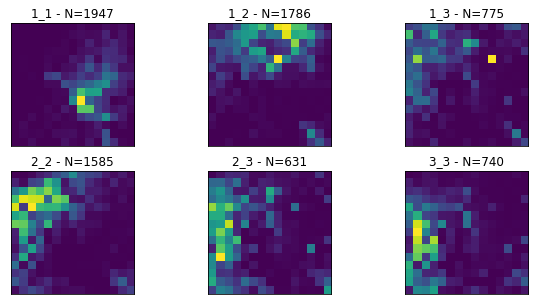

In [14]:
fig, axes = plt.subplots(2,3, figsize=(10,5))

for ax, key in zip(axes.flatten(), book.keys()):
    n = len(book[key])
    mean = np.array(book[key]).mean(axis=0)
    median = np.median(np.array(book[key]), axis=0)
    ax.imshow(mean)
    ax.set(title=f"{key} - N={n}")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
fig.show()


In [15]:
som = pu.som('../Experiment/Experiment_F3W2_95_5/Results/F3W2_95_5/F3W2S_95_5_3_74.bin')

/Users/gal16b/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


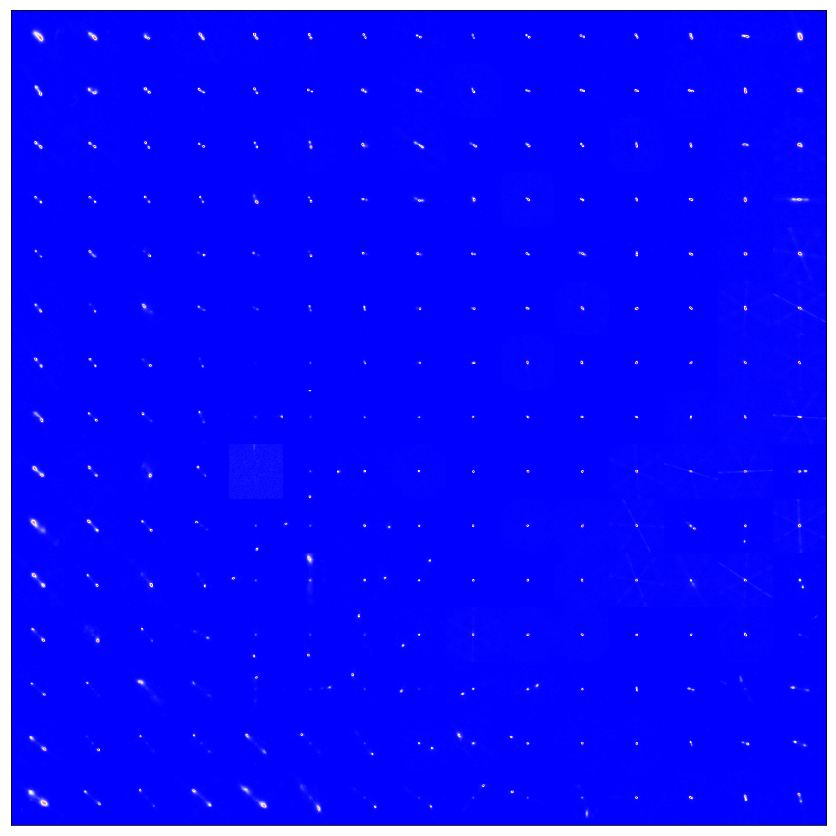

In [16]:
fig, ax  = plt.subplots(1,1, figsize=(15,15))

ax.imshow(som.get_som(channel=0), cmap='bwr')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

fig.show()

/Users/gal16b/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


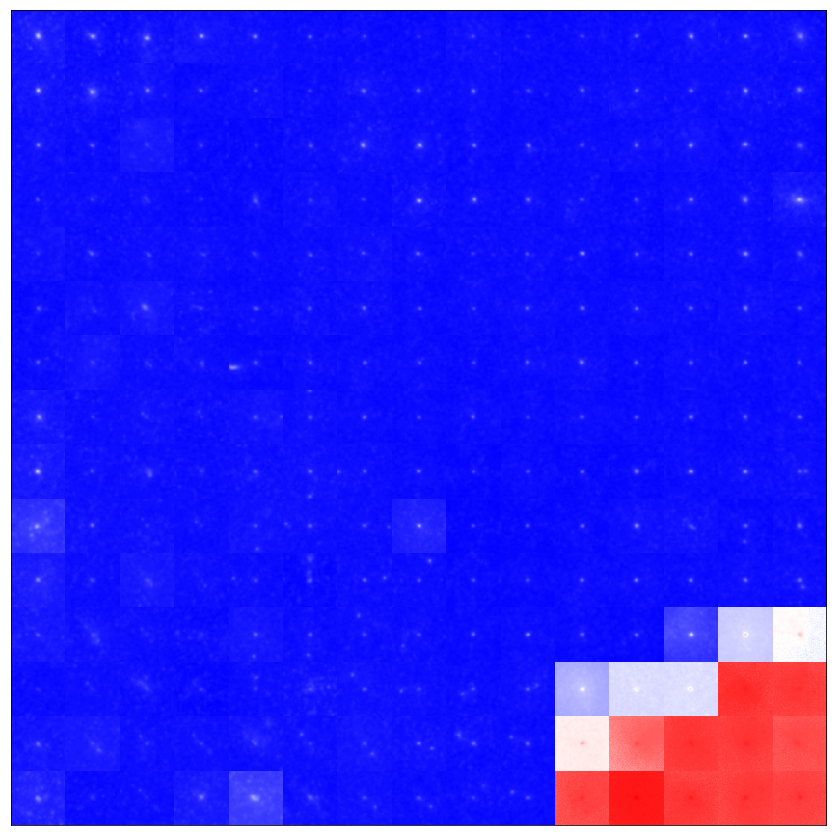

In [17]:
fig, ax  = plt.subplots(1,1, figsize=(15,15))

ax.imshow(som.get_som(channel=1), cmap='bwr')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

fig.show()

In [18]:
from sklearn.ensemble.forest import RandomForestRegressor

In [19]:
np.random.seed(7464)
index = np.random.permutation(len(maps))

labels = df['label']
num_comp  = np.array([int(i.split('_')[0]) for i in labels])
num_peaks = np.array([int(i.split('_')[1]) for i in labels])
heatmaps  = np.array(maps).reshape(-1,15*15)
total = heatmaps.shape[0]


In [191]:
no_folds = 5
results_peaks = []
results_comp = []
true_peaks = []
true_comp = []

for i in range(no_folds):
    xcTrain = np.concatenate([ heatmaps[index[:i*int(total/no_folds)]], heatmaps[index[(i+1)*int(total/no_folds):]]])
    ycTrain = np.concatenate([ num_comp[index[:i*int(total/no_folds)]], num_comp[index[(i+1)*int(total/no_folds):]]])
    
    print(i)
    print(xTrain.shape, yTrain.shape)

    xcTest = heatmaps[index[i*int(total/no_folds):(i+1)*int(total/no_folds)]]
    ycTest = num_comp[index[i*int(total/no_folds):(i+1)*int(total/no_folds)]]
    
#     print(xTest.shape, yTest.shape)

    nEstimators = 64 # how many trees, should be 256
    cores = 8 # number of cpu cores to speed it up

    print ("training random forest")
    rf = RandomForestRegressor(n_estimators=nEstimators, n_jobs=cores, bootstrap=True, verbose=0)
    rf.fit(xcTrain, ycTrain)

    results_comp = []
    
    for j in range(len(rf.estimators_)):
        results_comp.append(np.array(rf.estimators_[j].predict(xcTest)))
    results_comp = np.array(results_comp).T


    # ---------------------------------------------------------------
    
    xpTrain = np.concatenate([ heatmaps[index[:i*int(total/no_folds)]], heatmaps[index[(i+1)*int(total/no_folds):]]])
    ypTrain = np.concatenate([ num_peaks[index[:i*int(total/no_folds)]], num_peaks[index[(i+1)*int(total/no_folds):]]])
    
    print(i)
    print(xTrain.shape, yTrain.shape)

    xpTest = heatmaps[index[i*int(total/no_folds):(i+1)*int(total/no_folds)]]
    ypTest = num_peaks[index[i*int(total/no_folds):(i+1)*int(total/no_folds)]]
    
    print(xTest.shape, yTest.shape)
# 
#     nEstimators = 16 # how many trees, should be 256
    cores = 8 # number of cpu cores to speed it up

    print ("training random forest")
    rf = RandomForestRegressor(n_estimators=nEstimators, n_jobs=cores, bootstrap=True, verbose=0)
    rf.fit(xpTrain, ypTrain)

    results_peaks = []

    for j in range(len(rf.estimators_)):
        results_peaks.append(np.array(rf.estimators_[j].predict(xpTest)))
    results_peaks = np.array(results_peaks).T

    
    print (results_peaks.shape)
    print(results_peaks[:10])
    print(np.mean(results_peaks[:10], axis=1))
    print(ypTest[:10])
    
    break


0
(5972, 225) (5972,)
training random forest
0
(5972, 225) (5972,)
(1492, 225) (1492,)
training random forest
(1492, 64)
[[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 2.  3.  2.  3.  2.  2.  2.  2.  2.  3.  3.  2.  3.  2.  2.  2.  2.  2.
   2.  2.  2.  2.  1.  2.  3.  2.  2.  3.  2.  2.  2.  3.  2.  2.  2.  2.
   3.  2.  2.  2.  2.  2.  2.  3.  3.  2.  3.  2.  2.  3.  3.  2.  2.  2.
   3.  2.  3.  2.  3.  3.  3.  3.  2.  2.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
   1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 3.  3.  3.  2.  2.  2.  3.  3.  3.  3.  3.  3.  2.  3.  3.  2.  2.  3.
   3.  3. 

In [192]:
first_arr = np.array(first)
wise_arr = np.array(wise)


/Users/gal16b/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


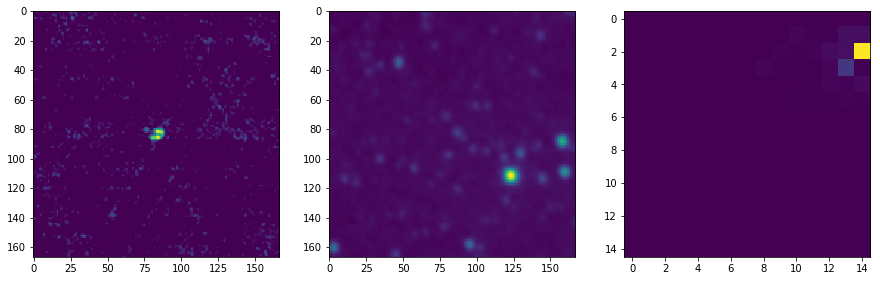

In [193]:
# i = 0
# xTest = heatmaps[index[i*int(total/no_folds):(i+1)*int(total/no_folds)]]

pos = 6

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,15))

ax1.imshow(first_arr[index[0*int(total/no_folds):(0+1)*int(total/no_folds)]][pos], interpolation='nearest')
ax2.imshow(wise_arr[index[0*int(total/no_folds):(0+1)*int(total/no_folds)]][pos], interpolation='nearest')
ax3.imshow(xcTest[pos].reshape(15,15))

fig.show()

# sub_df = df.iloc[index[0*int(total/no_folds):(0+1)*int(total/no_folds)]]
# sub_df.iloc[pos]

# print(type(0*int(total/no_folds)), type((0+1)*int(total/no_folds)))

In [194]:
print(num_comp[:5])

[1 1 1 1 1]


In [195]:
print(num_peaks[:5])

[1 1 1 1 1]


In [196]:
print(labels.loc[index].head())

1419    1_1
6854    3_3
1864    1_1
6825    3_3
4741    2_2
Name: label, dtype: object


/Users/gal16b/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


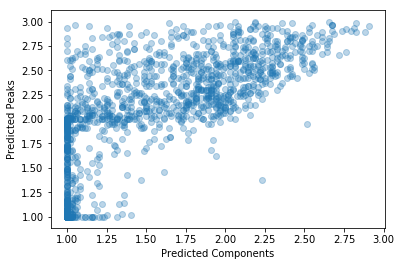

In [197]:
fig, ax = plt.subplots(1,1)

ax.scatter(np.array(results_comp).mean(axis=1),
           np.array(results_peaks).mean(axis=1),
          alpha=0.3)

ax.set(xlabel='Predicted Components',
       ylabel='Predicted Peaks')

fig.show()

/Users/gal16b/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


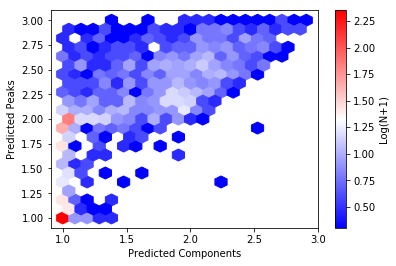

In [210]:
fig, ax = plt.subplots(1,1)

hb = ax.hexbin(np.array(results_comp).mean(axis=1),
               np.array(results_peaks).mean(axis=1),
               cmap='bwr',
               bins='log', gridsize=20, mincnt=1)

cb = fig.colorbar(hb, ax=ax)
cb.set_label('Log(N+1)')

ax.set(xlabel='Predicted Components',
       ylabel='Predicted Peaks')

fig.show()

/Users/gal16b/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


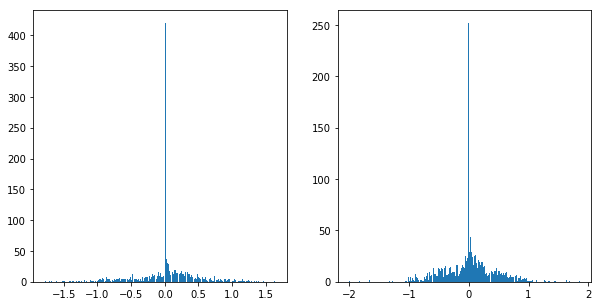

In [212]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))

ax1.hist( np.array(results_comp).mean(axis=1) - ycTest, bins=250 )
ax2.hist( np.array(results_peaks).mean(axis=1) - ypTest, bins=250 )

fig.show()